# **APPLIED STATISTICS PROJECT**

## **Analysis of ADT dataset**

## Uploadings of packages and datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import shap
import mudata
import scanpy as sc
import anndata as ad


In [ ]:
# Import datasets
rna_data = sc.read_h5ad("/Users/eli/Desktop/progetto applied/dataset_applied/sampled_full_AML_RNA.h5ad")
adt_data=sc.read_h5ad("/Users/eli/Desktop/progetto applied/dataset_applied/sampled_full_AML_ADT.h5ad")

In [ ]:
# Print dataset dimensions
print(rna_data.shape)
print(adt_data.shape)

(211969, 36601)
(211969, 61)


In [ ]:
# Head of adt_data to see an example of the dataset
print(adt_data.obs.head())

                                     sample  n_genes_by_counts  \
AACCAACCATGAAGGC-1_SRR16208932  SRR16208932                 65   
AGACCCGAGAATACAC-1_SRR16208931  SRR16208931                 65   
TGCACGGAGTAGTCTC-1_SRR16208932  SRR16208932                 62   
CTTTCAAGTATATGGA-1_SRR16208932  SRR16208932                 53   
ACCAAACTCGTTTACT-1_SRR16208930  SRR16208930                 60   

                                log1p_n_genes_by_counts  total_counts  \
AACCAACCATGAAGGC-1_SRR16208932                 4.189655        1472.0   
AGACCCGAGAATACAC-1_SRR16208931                 4.189655         847.0   
TGCACGGAGTAGTCTC-1_SRR16208932                 4.143135         324.0   
CTTTCAAGTATATGGA-1_SRR16208932                 3.988984         444.0   
ACCAAACTCGTTTACT-1_SRR16208930                 4.110874         376.0   

                                log1p_total_counts sample_demult  
AACCAACCATGAAGGC-1_SRR16208932            7.295056        PAWWEE  
AGACCCGAGAATACAC-1_SRR16208931

In [ ]:
# Columns of adt_data
print(adt_data.obs.columns)

Index(['sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'sample_demult'],
      dtype='object')


In [ ]:
# Add column age

adt_data.obs['sample'] = adt_data.obs['sample'].str.strip()
rna_data.obs['sample'] = rna_data.obs['sample'].str.strip()

# Create a map sample -> age
sample_to_age = rna_data.obs.drop_duplicates('sample').set_index('sample')['age'].to_dict()

# Add 'age' to adt_data.obs
adt_data.obs['age'] = adt_data.obs['sample'].map(sample_to_age)

# Verify the result
print(adt_data.obs[['sample', 'age']].head())


                                     sample            age
AACCAACCATGAAGGC-1_SRR16208932  SRR16208932  Pediatric_AML
AGACCCGAGAATACAC-1_SRR16208931  SRR16208931  Pediatric_AML
TGCACGGAGTAGTCTC-1_SRR16208932  SRR16208932  Pediatric_AML
CTTTCAAGTATATGGA-1_SRR16208932  SRR16208932  Pediatric_AML
ACCAAACTCGTTTACT-1_SRR16208930  SRR16208930  Pediatric_AML


In [ ]:
# Columns of each data frame
print(adt_data.obs.columns)

Index(['sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'sample_demult'],
      dtype='object')


# Data exploration

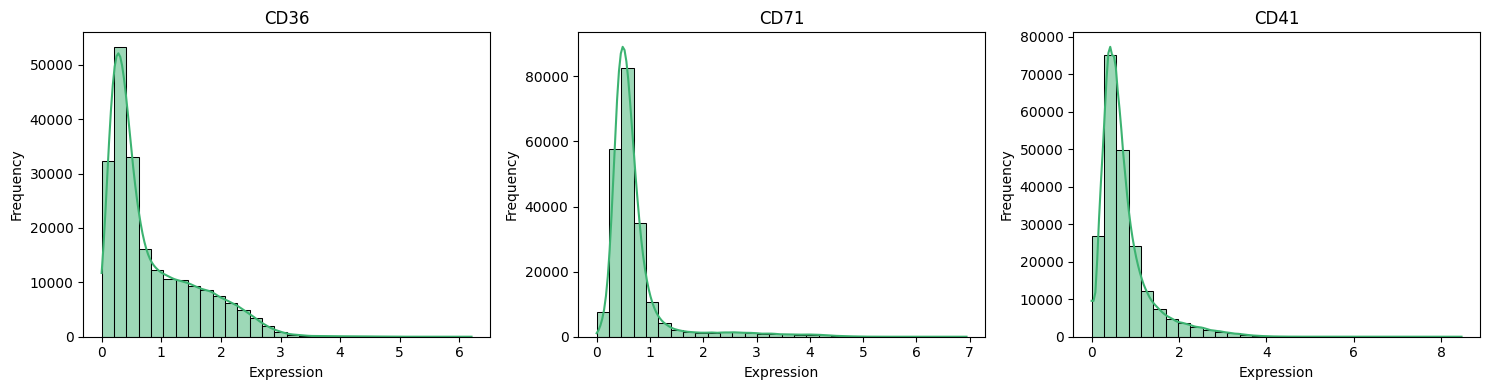

In [ ]:
# Compute variance for each protein
X_dense = adt_data.X.toarray() if hasattr(adt_data.X, "toarray") else adt_data.X
protein_variances = np.var(X_dense, axis=0)
var_series = pd.Series(protein_variances, index=adt_data.var_names)
top_proteins = var_series.sort_values(ascending=False).head(3)
top_protein_names = top_proteins.index.tolist()

# Select the expression profiles of the top variable proteins
top_matrix = adt_data[:, top_protein_names].X.toarray() if hasattr(adt_data.X, "toarray") else adt_data[:, top_protein_names].X
top_df = pd.DataFrame(top_matrix, columns=top_protein_names)

# Plot some protein ditributions
plt.figure(figsize=(15, 4))
for i, protein in enumerate(top_protein_names):
    plt.subplot(1, 3, i + 1)
    sns.histplot(top_df[protein], bins=30, kde=True, color="mediumseagreen")
    plt.title(protein)
    plt.xlabel("Expression")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


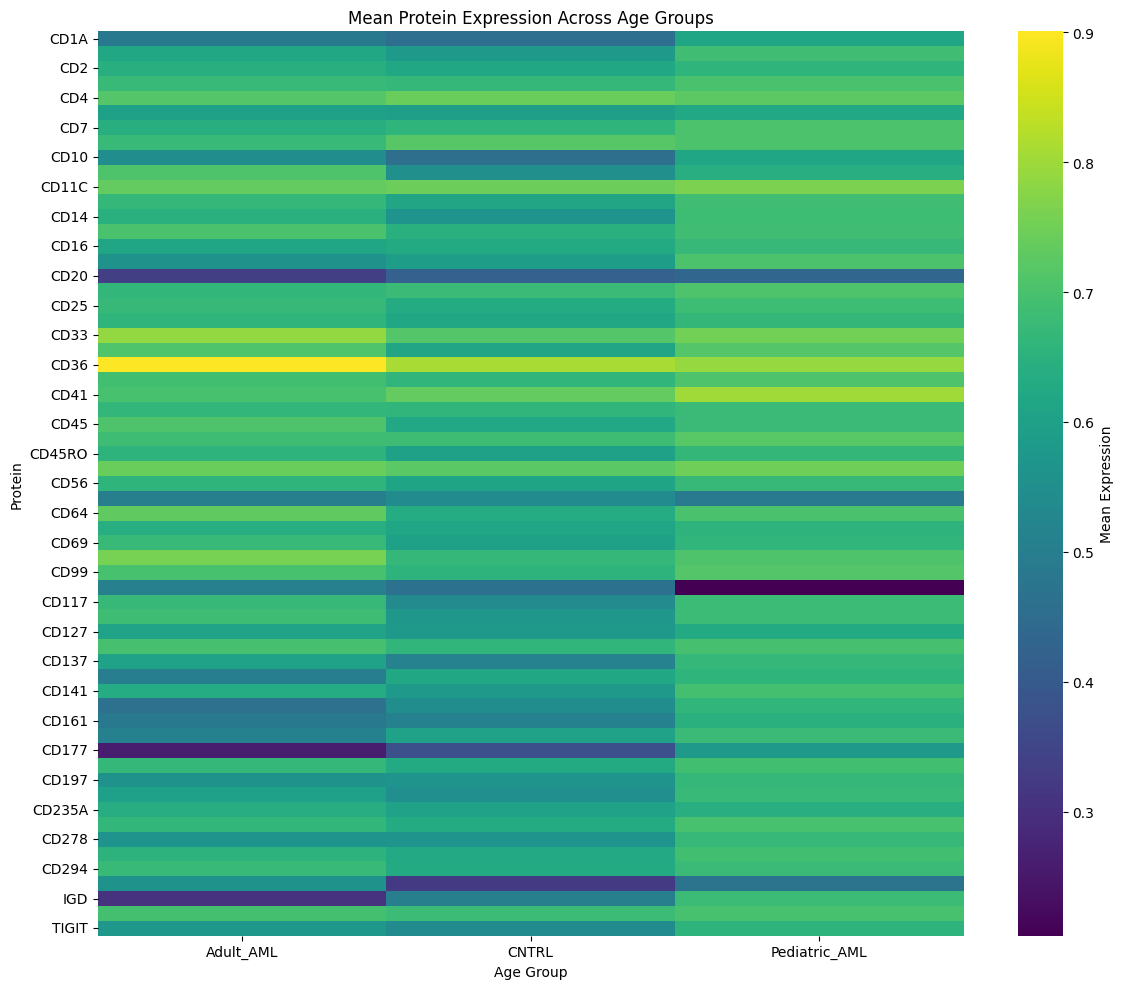

In [ ]:
# Extract protein expression into a DataFrame
protein_df = pd.DataFrame(adt_data.X.toarray(), columns=adt_data.var_names, index=adt_data.obs_names)

# Add age
protein_df['age'] = adt_data.obs['age'].values

# Compute the mean expression of each protein for every age group
group_means = protein_df.groupby('age').mean()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(group_means.T, cmap='viridis', cbar_kws={'label': 'Mean Expression'})
plt.title("Mean Protein Expression Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Protein")
plt.tight_layout()
plt.show()



In [ ]:
# Extract expression matrix and group labels
protein_df = pd.DataFrame(adt_data.X.toarray(), columns=adt_data.var_names, index=adt_data.obs_names)
protein_df['age'] = adt_data.obs['age'].values

# Compute mean expression per protein in each group
group_means = protein_df.groupby('age').mean()

# Compute standard deviation of means across age groups
protein_variability = group_means.std(axis=0).sort_values(ascending=False)

# Show top 10 most variable proteins
top_variable_proteins = protein_variability.head(10)
print("Top 10 most variable proteins across age groups:")
print(top_variable_proteins)


Top 10 most variable proteins across age groups:
IGD       0.187419
CD177     0.164039
CD115     0.163211
HLA-DR    0.119062
CD152     0.099791
CD161     0.086974
CD1A      0.086545
CD163     0.083902
CD117     0.081431
CD138     0.081339
dtype: float32


In [ ]:
# Take the frist 10 most variable proteins
top_10_proteins = var_series.sort_values(ascending=False).head(10)

# Show their names
print("Top 10 proteine più variabili:")
print(top_10_proteins.index.tolist())

Top 10 proteine più variabili:
['CD36', 'CD71', 'CD41', 'CD33', 'CD4', 'CD2', 'CD8', 'CD5', 'CD11C', 'CD66B']


## Load the preprocessed datasets

In [ ]:
# Check preprocessing.ipynb to see how they are created
df_pca_40_loaded = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/pca_adt_40components_with_age.csv")

print("Shape scores:", df_pca_40_loaded.shape)
print("Colonne:", df_pca_40_loaded.columns.tolist())
print(df_pca_40_loaded.head())


Shape scores: (434, 43)
Colonne: ['patient_id', 'cell_type', 'age', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40']
    patient_id  cell_type            age       PC1       PC2       PC3  \
0  SRR16208932     B cell  Pediatric_AML -0.634264 -0.016750  1.155500   
1  SRR16208932     B_prog  Pediatric_AML -0.373123  0.038531  1.053429   
2  SRR16208932        CLP  Pediatric_AML -1.528707 -0.120222  0.663271   
3  SRR16208932  Early GMP  Pediatric_AML -1.246423  0.163569  0.544217   
4  SRR16208932  Erythroid  Pediatric_AML -0.819274  1.794409  0.288504   

        PC4       PC5       PC6       PC7  ...      PC31      PC32      PC33  \
0 -0.822750  1.232215 -0.270398  0.104778  ...  0.032277 -0.009011 -0.042134   
1 -0.524593  0.9

In [ ]:
df_loadings = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/pca_adt_40components_loadings.csv")

print("Shape loadings:", df_loadings.shape)
print("Colonne:", df_loadings.columns.tolist())
print(df_loadings.head())


Shape loadings: (61, 41)
Colonne: ['Unnamed: 0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40']
  Unnamed: 0       PC1       PC2       PC3       PC4       PC5       PC6  \
0       CD1A  0.148587 -0.038478 -0.061040  0.017182  0.037334  0.090088   
1       CD1C  0.135481 -0.025253 -0.041255 -0.019406  0.067908  0.055738   
2        CD2  0.211216 -0.147119  0.315668  0.247218 -0.191721 -0.036494   
3        CD3  0.117087 -0.082373  0.204854  0.139693 -0.022155  0.078038   
4        CD4  0.163029  0.136570  0.067104  0.002819 -0.129578  0.018022   

        PC7       PC8       PC9  ...      PC31      PC32      PC33      PC34  \
0  0.007901 -0.087204 -0.032092  ...  0.272070 -0.140024 -0.165408  0.319523   
1 -0.027404 -0.001504  

# Supervised learning

### Random Forest

In [ ]:
pc_cols = [f'PC{i+1}' for i in range(40)]
X = df_pca_40_loaded[pc_cols].values

y = df_pca_40_loaded['age'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluate model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9389312977099237
               precision    recall  f1-score   support

    Adult_AML       0.95      0.95      0.95        40
        CNTRL       0.89      1.00      0.94        34
Pediatric_AML       0.96      0.89      0.93        57

     accuracy                           0.94       131
    macro avg       0.94      0.95      0.94       131
 weighted avg       0.94      0.94      0.94       131



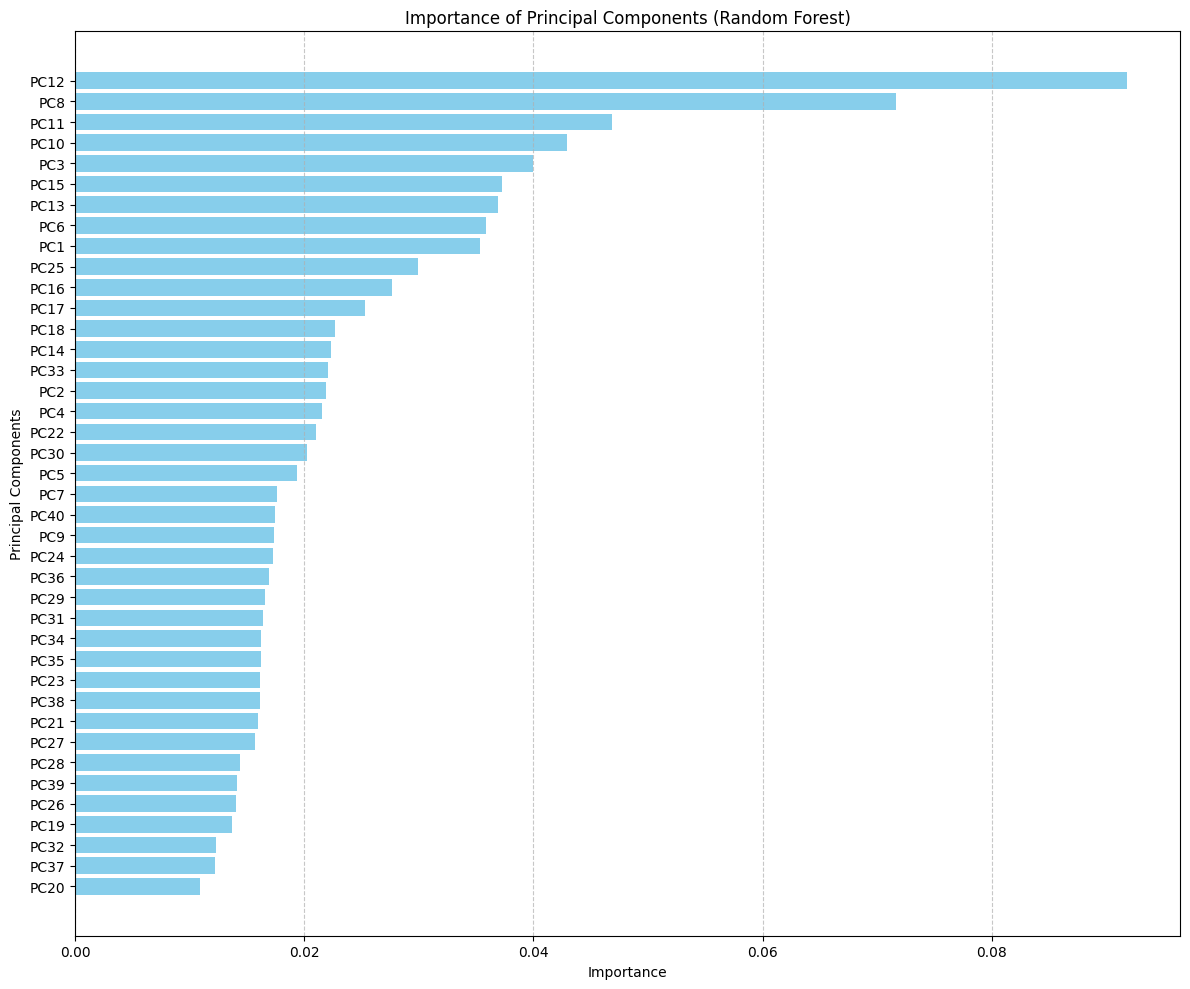

In [ ]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to associate them with the PCs
feature_names = [f"PC{i+1}" for i in range(X.shape[1])]
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by descending importance
importances_df_sorted = importances_df.sort_values(by='Importance', ascending=True)

# Plot all PCs in ascending order
plt.figure(figsize=(12, 10))
plt.barh(importances_df_sorted['Feature'], importances_df_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Principal Components')
plt.title('Importance of Principal Components (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
# Select only numerical columns
X = df_pca_40_loaded.select_dtypes(include=[np.number])


if 'age' in X.columns:
    X = X.drop(columns=['age'])

# Define target variable y
y = df_pca_40_loaded['age'].values

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=21, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# SHAP explanation
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap_array = np.array(shap_values)

mean_abs_shap_per_class = np.mean(np.abs(shap_array), axis=1)
mean_shap_importance = np.mean(mean_abs_shap_per_class, axis=0)

# Get feature names
feature_names = list(X_train.columns)


/Users/eli/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Feature,SHAP_Importance
11,PC12,0.073788
7,PC8,0.059587
10,PC11,0.026528
2,PC3,0.026079
9,PC10,0.025507
5,PC6,0.020338
15,PC16,0.018026
12,PC13,0.017507
1,PC2,0.017303
0,PC1,0.017248


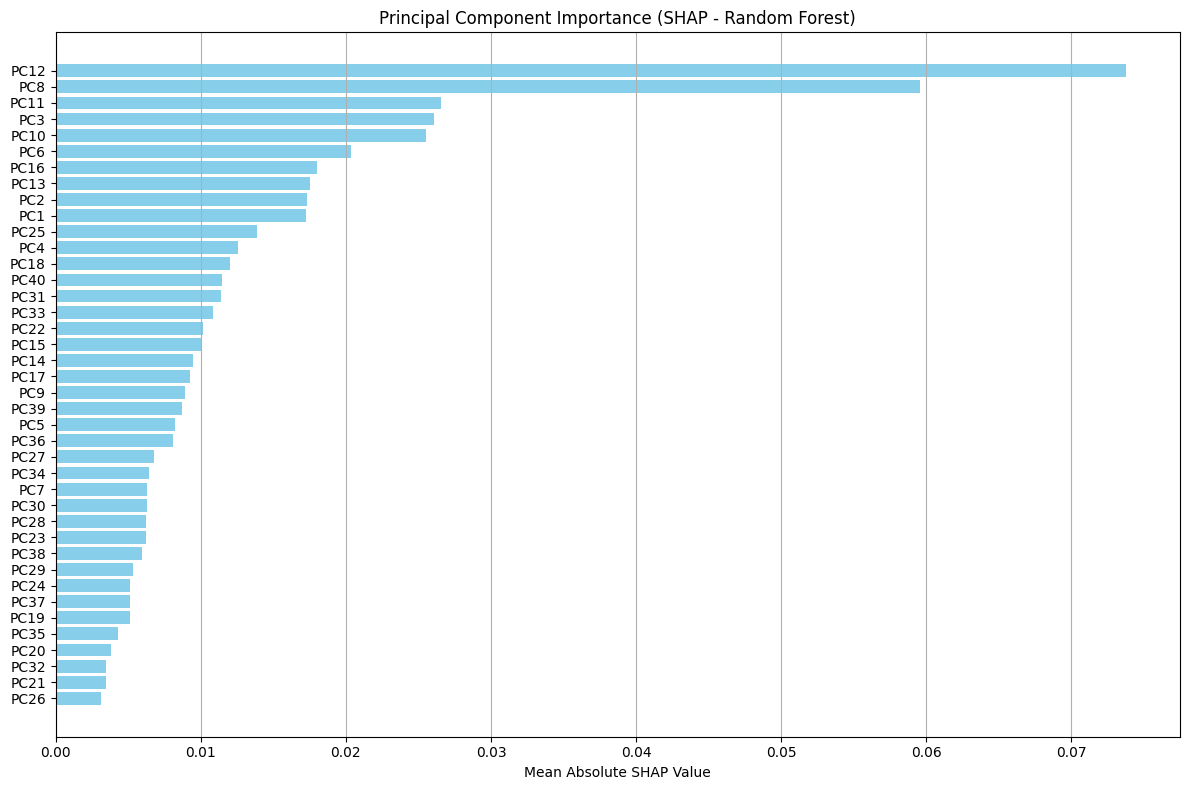

In [ ]:
# Convert the list of shap_values to a NumPy array
shap_values_array = np.array(shap_values)

if shap_values_array.ndim == 3:
    mean_shap_importance = np.mean(np.abs(shap_values_array), axis=(0, 2))
elif shap_values_array.ndim == 2:
    mean_shap_importance = np.mean(np.abs(shap_values_array), axis=0)
else:
    raise ValueError("Unrecognized shap_values format")


feature_names = [f'PC{i+1}' for i in range(len(mean_shap_importance))]

# Build a DataFrame sorted by decreasing importance
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': mean_shap_importance
}).sort_values(by='SHAP_Importance', ascending=False)

# Display table
display(shap_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(shap_df['Feature'][::-1], shap_df['SHAP_Importance'][::-1], color='skyblue')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Principal Component Importance (SHAP - Random Forest)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [ ]:
# Import the dataset
adt_data = pd.read_csv("protein_agg.csv", index_col=[0,1])

# Show a preview
print(adt_data.head())

                           CD1A      CD1C       CD2       CD3      CD4  \
patient_id  cell_type                                                    
SRR16208932 B cell     0.000000  0.434405  0.000000  0.536177  0.32829   
            B_prog     0.519078  0.434405  0.393461  0.883320  0.57503   
            CLP        0.859067  0.736248  0.675087  0.665748  0.32829   
            Early GMP  0.000000  0.434405  0.393461  0.665748  0.57503   
            Erythroid  0.259539  0.434405  0.393461  0.665748  0.45166   

                            CD5       CD7       CD8      CD10    CD11B  ...  \
patient_id  cell_type                                                   ...   
SRR16208932 B cell     0.743943  0.620490  0.609447  0.693831  0.41581  ...   
            B_prog     0.775710  0.620490  0.609447  1.446230  0.41581  ...   
            CLP        0.524808  0.620490  0.350450  0.405921  0.00000  ...   
            Early GMP  0.603311  0.620490  0.350450  0.405921  0.41581  ...   
       

In [ ]:
# Select top 5 proteins with largest absolute loadings for each PC

df_loadings = df_loadings.set_index('Unnamed: 0')

# List of principal component indices to analyze
pc_indices = [12, 8, 11, 3, 10, 6]

top_proteins = set()

# Loop over each selected principal component index
for idx in pc_indices:
    pc_name = f'PC{idx}'
    component_loadings = df_loadings[pc_name]
    # Select top 5 proteins with largest absolute loadings for this PC
    top_proteins_pc = component_loadings.abs().nlargest(5).index.tolist()

    top_proteins.update(top_proteins_pc)

# Sort the unique top proteins
top_proteins_list = sorted(top_proteins)

# Print the selected proteins and the total count
print("Selected proteins:", top_proteins_list)
print("Total unique proteins:", len(top_proteins_list))



Selected proteins: ['CD10', 'CD115', 'CD117', 'CD11B', 'CD11C', 'CD123', 'CD134', 'CD137', 'CD141', 'CD16', 'CD2', 'CD20', 'CD244', 'CD34', 'CD4', 'CD42B', 'CD48', 'CD5', 'CD7', 'CD99', 'IGD']
Total unique proteins: 21


In [ ]:
# Extract patient_id from first element of MultiIndex tuple
patient_ids = [name[0] for name in adt_data.index]

# Load age data CSV and set 'patient_id' as index
age_df = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/patients_age.csv")
age_df = age_df.drop_duplicates(subset='patient_id').set_index('patient_id')

df_selected = adt_data[top_proteins_list].copy()

patient_ids_series = pd.Series(patient_ids, index=df_selected.index)

# Map age using patient_ids
df_selected['age'] = patient_ids_series.map(age_df['age'])

print(df_selected[['age']].head())


                                 age
patient_id  cell_type               
SRR16208932 B cell     Pediatric_AML
            B_prog     Pediatric_AML
            CLP        Pediatric_AML
            Early GMP  Pediatric_AML
            Erythroid  Pediatric_AML


In [ ]:
df_selected = df_selected.dropna(subset=['age'])
df_selected['age'] = df_selected['age'].astype(str)

X = df_selected.drop(columns=['age'])
y = df_selected['age']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.5, random_state=42, stratify=y_encoded)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9400921658986175
               precision    recall  f1-score   support

    Adult_AML       0.98      0.98      0.98        66
        CNTRL       0.85      0.96      0.90        57
Pediatric_AML       0.98      0.89      0.93        94

     accuracy                           0.94       217
    macro avg       0.94      0.95      0.94       217
 weighted avg       0.94      0.94      0.94       217

